In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import optax
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs, make_circles
from tinygp import kernels
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.scipy as jsp

# Partially initialize functions
from functools import partial

# TFP
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# GP Kernels

# sklearn

# Optimization

# Plotting
plt.rcParams['scatter.edgecolors'] = "k"

# Progress bar

# Jitter
JITTER = 1e-6

# Enable JAX 64bit
jax.config.update("jax_enable_x64", True)


2022-11-16 16:15:09.785337: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 16:15:10.339069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:/opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-11-16 16:15:10.339173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/l

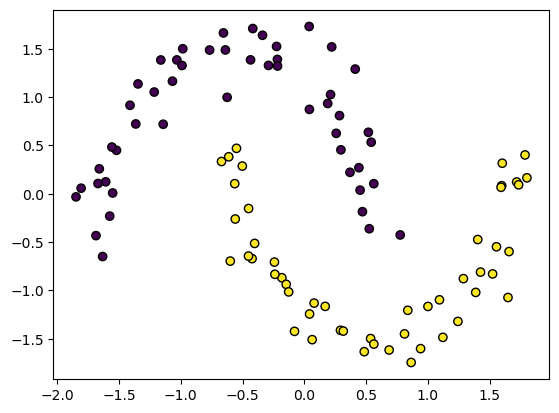

In [2]:
n_samples = 100
noise = 0.1
random_state = 0
shuffle = True

X, y = make_moons(
    n_samples=n_samples, random_state=random_state, noise=noise, shuffle=shuffle
)
X = StandardScaler().fit_transform(X)  # Yes, this is useful for GPs

X, y = map(jnp.array, (X, y))

plt.scatter(X[:, 0], X[:, 1], c=y);

In [3]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

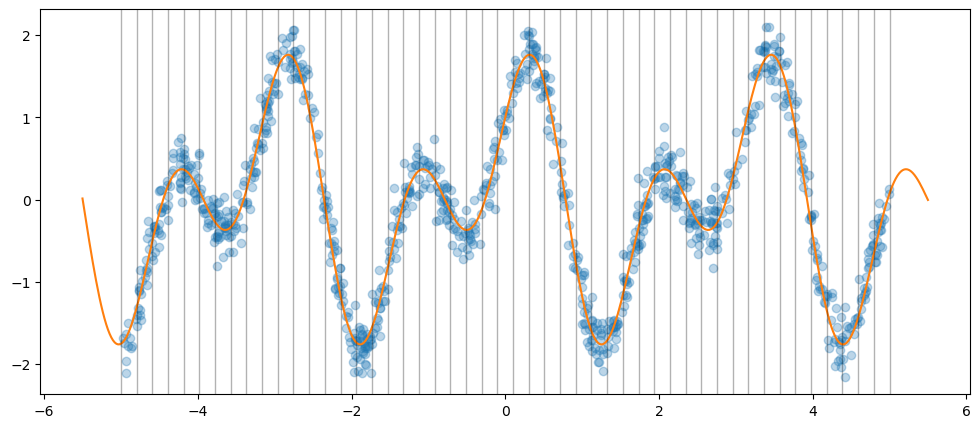

In [4]:

import jax.random as jr
key = jax.random.PRNGKey(0)
n = 1000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0,
               shape=(n,)).sort().reshape(-1, 1)


def f(x): return jnp.sin(4 * x) + jnp.cos(2 * x)


signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3, label="Samples")
ax.plot(xtest, f(xtest), label="True function")
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()


In [5]:
x_samples = x
y_samples = y

In [6]:
X = x

In [7]:
lengthscale = 1.0
variance = 1.0

kernel_fn = variance * kernels.ExpSquared(scale=lengthscale) # 

kernel_fn(X, X).shape


(1000, 1000)

In [8]:
key = jax.random.PRNGKey(0)
n_inducing = 10
n_dim = X.shape[1]

X_inducing = jax.random.normal(key, shape=(n_inducing, n_dim))
X_inducing.shape


(10, 1)

In [47]:
class SVGP:
    def __init__(self, X_inducing, data_size):
        self.X_inducing = X_inducing
        self.n_inducing = len(X_inducing)
        self.data_size = data_size

    def init_params(self, seed):
        variational_corr_chol_param = tfb.CorrelationCholesky().inverse(
            jnp.eye(self.n_inducing))

        dummy_params = {"log_variance": jnp.zeros(()),
                        "log_scale": jnp.zeros(()),
                        "mean": jnp.zeros(()),
                        "X_inducing": self.X_inducing,
                        "variational_mean": jnp.zeros(self.n_inducing),
                        "variational_corr_chol_param": variational_corr_chol_param,
                        "log_variational_sigma": jnp.zeros((self.n_inducing, 1)),
                        }

        flat_params, unravel_fn = ravel_pytree(dummy_params)
        random_params = jax.random.normal(key, shape=(len(flat_params), ))
        params = unravel_fn(random_params)
        return params

    @staticmethod
    def get_constrained_params(params):
        return {"mean": params["mean"],
                "variance": jnp.exp(params['log_variance']),
                "scale": jnp.exp(params['log_scale']),
                "X_inducing": params["X_inducing"],
                "variational_mean": params["variational_mean"],
                "variational_corr_chol_param": params["variational_corr_chol_param"],
                "variational_sigma": jnp.exp(params["log_variational_sigma"])}

    @staticmethod
    def get_q_f(params, x_i, prior_distribution, variational_distribution):
        x_i = x_i.reshape(1, -1)  # ensure correct shape

        kernel_fn = params['variance'] * \
            kernels.ExpSquared(scale=params["scale"])
        K_im = kernel_fn(x_i, params["X_inducing"])
        K_mm = prior_distribution.covariance()
        chol_mm = jnp.linalg.cholesky(K_mm)
        A = jsp.linalg.cho_solve((chol_mm, True), K_im.T).T

        mu_i = A@params["variational_mean"]
        sigma_sqr_i = kernel_fn(
            x_i, x_i) + A@(variational_distribution.covariance() - K_mm)@A.T # 

        return tfd.Normal(loc=mu_i, scale=sigma_sqr_i**0.5) # 

    def get_distributions(self, params):
        kernel_fn = params['variance'] * \
            kernels.ExpSquared(scale=params["scale"])
        prior_mean = params["mean"]
        prior_cov = kernel_fn(
            params["X_inducing"], params["X_inducing"]) + jnp.eye(self.n_inducing)*JITTER
        prior_distribution = tfd.MultivariateNormalFullCovariance(
            prior_mean, prior_cov)

        corr_chol = tfb.CorrelationCholesky()(
            params["variational_corr_chol_param"])
        sigma = jnp.diag(params["variational_sigma"])
        variational_cov = sigma*sigma.T * \
            (corr_chol@corr_chol.T) + jnp.eye(self.n_inducing)*JITTER
        variational_distribution = tfd.MultivariateNormalFullCovariance(
            params["variational_mean"], variational_cov)

        return prior_distribution, variational_distribution

    def loss_fn(self, params, X_batch, y_batch, seed):
        params = self.get_constrained_params(params)
        diff = jnp.std(params['X_inducing'])
        # Get distributions
        prior_distribution, variational_distribution = self.get_distributions(
            params)

        # Compute kl
        kl = variational_distribution.kl_divergence(prior_distribution)

        # Compute log likelihood
        def log_likelihood_fn(x_i, y_i, seed):
            q_f = self.get_q_f(params, x_i, prior_distribution,
                               variational_distribution)
            log_likelihood = q_f.log_prob(y_i)
            return log_likelihood.squeeze()

        seeds = jax.random.split(seed, num=len(y_batch))
        log_likelihood = jax.vmap(log_likelihood_fn)(
            X_batch, y_batch, seeds).sum() * self.data_size/len(y_batch)

        return kl - log_likelihood - 1000*diff

    def fit_fn(self, X, y, init_params, optimizer, n_iters, batch_size, seed):
        state = optimizer.init(init_params)
        value_and_grad_fn = jax.value_and_grad(self.loss_fn)

        def one_step(params_and_state, seed):
            params, state = params_and_state
            idx = jax.random.choice(
                seed, self.data_size, (batch_size,), replace=False)
            X_batch, y_batch = X[idx], y[idx]

            seed2 = jax.random.split(seed, 1)[0]
            loss, grads = value_and_grad_fn(params, X_batch, y_batch, seed2)
            updates, state = optimizer.update(grads, state)
            params = optax.apply_updates(params, updates)
            return (params, state), (loss, params)

        seeds = jax.random.split(seed, num=n_iters)
        (best_params, _), (loss_history, params_history) = jax.lax.scan(
            one_step, (init_params, state), xs=seeds)
        return best_params, loss_history, params_history

    def predict_fn(self, params, X_new):
        constrained_params = self.get_constrained_params(params)
        prior_distribution, variational_distribution = self.get_distributions(
            constrained_params)

        def _predict_fn(x_i):
            # Get posterior
            q_f = self.get_q_f(constrained_params, x_i,
                               prior_distribution, variational_distribution)
            return q_f.mean().squeeze(), q_f.variance().squeeze()

        mean, var = jax.vmap(_predict_fn)(X_new)
        return mean.squeeze(), var.squeeze()


In [48]:
n_inducing = 10
n_epochs = 100
batch_size = 10
data_size = len(y)
n_iters = n_epochs*(data_size/batch_size)
n_iters


10000.0

In [49]:
def do_work(n = 10, batch = 10, x_samples = x_samples, n_epochs = n_epochs): 
    n_inducing = n
    batch_size = batch
    key = jax.random.PRNGKey(0)
    key2, subkey = jax.random.split(key)
    optimizer = optax.adam(learning_rate=0.01) 

    X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
    model = SVGP(X_inducing, data_size)

    init_params = model.init_params(key2)
    n_iters = n_epochs*(data_size/batch_size)

    model.loss_fn(init_params, X, y, key)
    best_params, loss_history, params_history = model.fit_fn(
        X, y, init_params, optimizer, n_iters, batch_size, subkey)

    plt.figure()
    # plt.plot(loss_history)
    # plt.title("Loss")
    x = jnp.linspace(-5, 5, 300)
    seed = jax.random.PRNGKey(123)

    X1, X2 = jnp.meshgrid(x, x)
    def f(x1): return model.predict_fn(best_params, jnp.array([x1]).reshape(1, -1)) 

    pred_mean, pred_var = jax.vmap(jax.vmap(f))(X1)
    plt.plot(X, y, "o", alpha=0.3, label="Samples")
    plt.plot(x, pred_mean[0], linewidth=2)
    plt.fill_between(x, pred_mean[0] - 2*pred_var[0] **
                    0.5, pred_mean[0] + 2*pred_var[0]**0.5, alpha=0.3)
    plt.plot(best_params['X_inducing'], jnp.zeros(
        best_params['X_inducing'].shape) - 5, "x")
    plt.savefig(f'./image_epochs/s{n_epochs:04d}.png')
    x_ = jnp.linspace(-5, 5, 300)
    def g(x): return jnp.sin(4 * x) + jnp.cos(2 * x)

    # print(jnp.sum((g(X1)[0] - pred_mean[0])**2)/300)

    # return jnp.sum((g(X1)[0] - pred_mean[0])**2)/300
    msll = mean_standardized_log_loss(pred_mean[0], g(X1)[0], pred_var[0])
    print(msll)
    return pred_mean, pred_var, best_params['X_inducing'], msll
    



In [50]:
loss_arr= []

In [51]:
# 1.23 minutes

In [2]:
for i in range(120)[10::10]:
    print(i)

10
20
30
40
50
60
70
80
90
100
110


0.8355868103374182
0.14198379505362793
-0.7249103424710183
0.3354122461818442
-0.08427253088812066
-0.05967049035189097
0.10322829884127548
0.17492790269775624


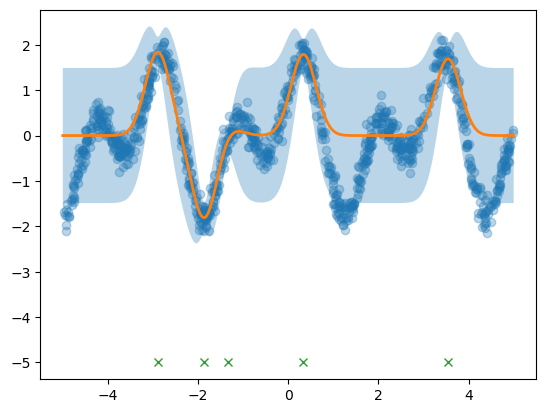

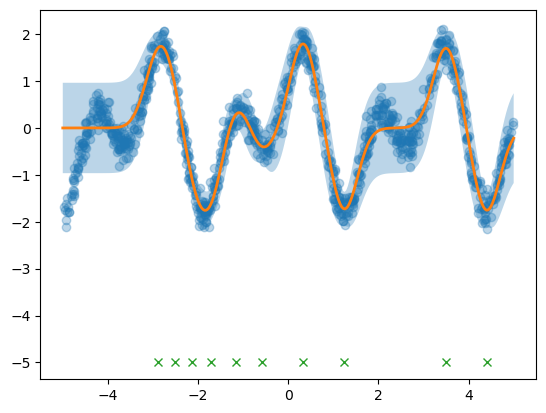

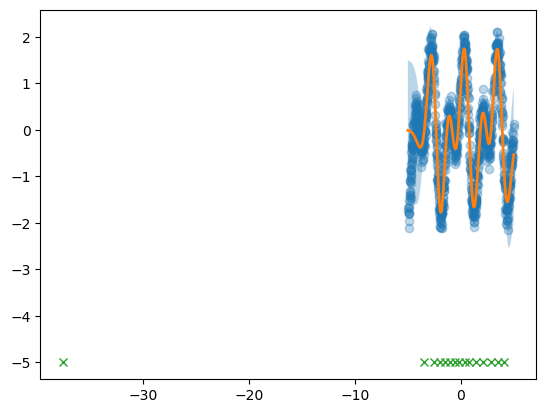

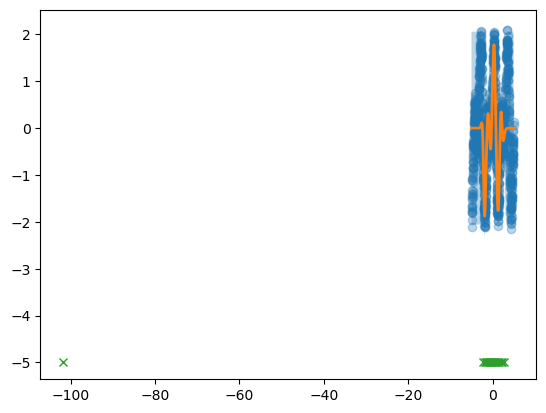

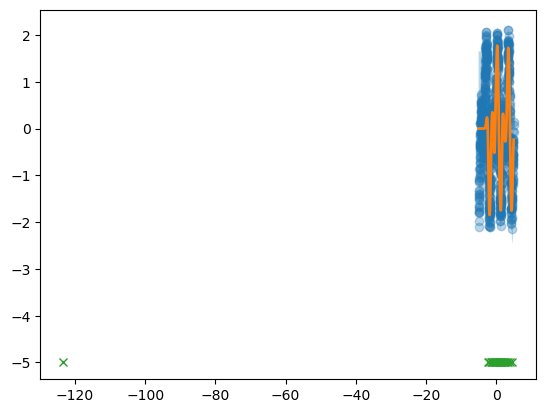

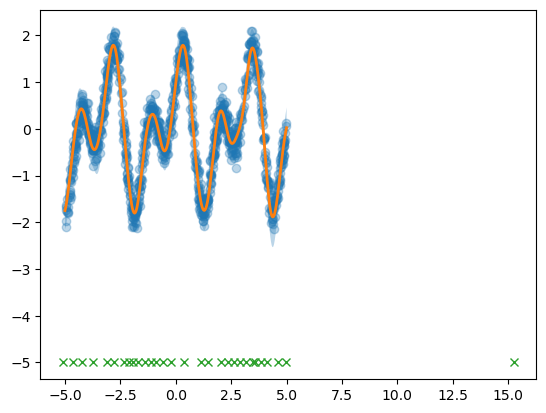

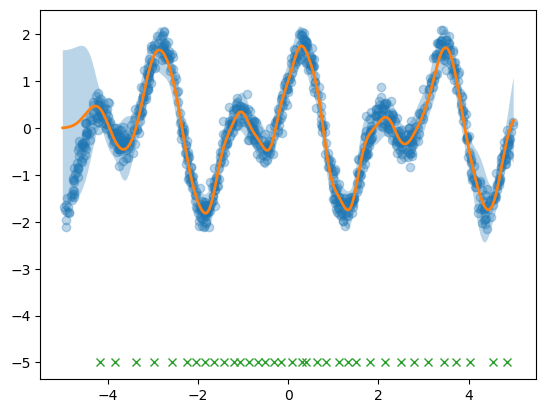

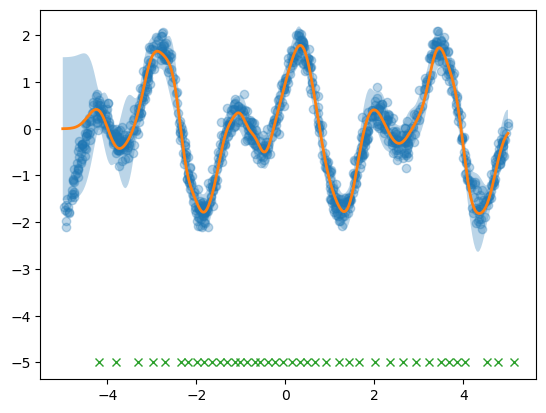

In [52]:
for n in [5, 10, 15, 20, 25, 30, 35, 40]:
    y_pred, y_var, y_inducing, loss = do_work(n=n, n_epochs=200)
    loss_arr.append(loss)

In [39]:
loss_arr1 = loss_arr[:8]
loss_arr2 = loss_arr[8:]

In [43]:
len(loss_arr2), len(loss_arr1)

(8, 8)

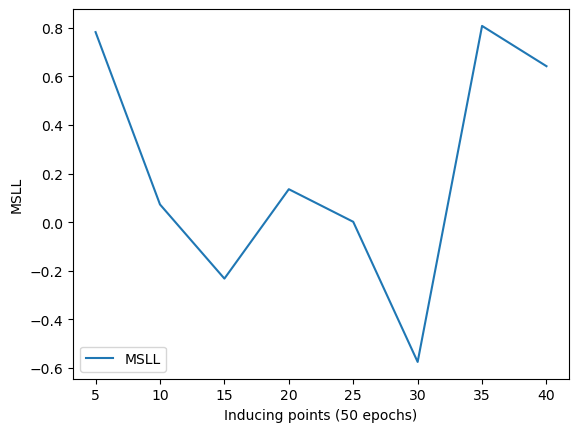

In [58]:
plt.plot([5,10,15,20,25,30,35,40], loss_arr2, label = "MSLL")
# set x label to msll
plt.xlabel("Inducing points (50 epochs)")
plt.ylabel('MSLL')
plt.legend()
plt.show()

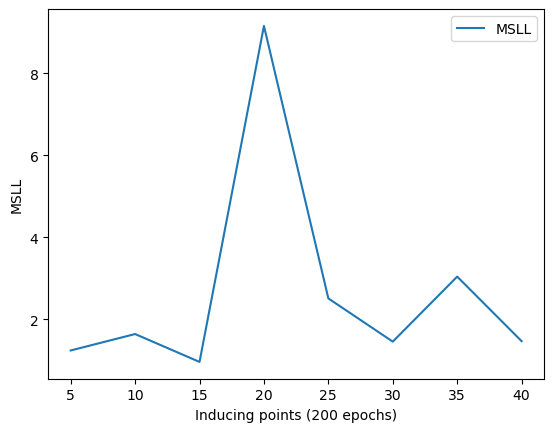

In [59]:
plt.plot([5,10,15,20,25,30,35,40], loss_arr1, label = "MSLL")
# set x label to msll
plt.xlabel("Inducing points (200 epochs)")
plt.ylabel('MSLL')
plt.legend()
plt.show()

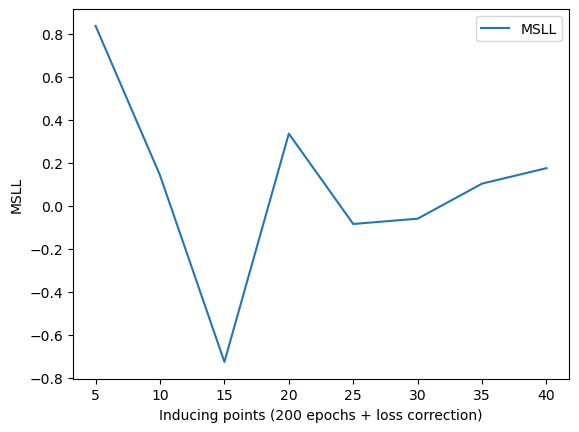

In [60]:
plt.plot([5,10,15,20,25,30,35,40], loss_arr, label = "MSLL")
# set x label to msll
plt.xlabel("Inducing points (200 epochs + loss correction)")
plt.ylabel('MSLL')
plt.legend()
plt.show()

In [ ]:
loss

0.7736255912366229

In [ ]:
stack = np.dstack((jnp.linspace(-5, 5, 300), y_pred[0]))


In [ ]:
x_samples.shape[0]

1000

In [ ]:
find_nearest(jnp.linspace(-5, 5, 300), x_samples[3])

-4.933110367892976

In [ ]:
count

1000

In [ ]:
y_lis = []

In [ ]:
for i in range(x_samples.shape[0]):
    ind = np.where(jnp.linspace(-5,5,300) == find_nearest(jnp.linspace(-5, 5, 300), x_samples[i]))
    # diff = y_pred[0][ind] - y_samples[i]
    y_lis.append(y_pred[0][ind])
    # upper = y_pred[0][ind] - 1.96*y_var[0][ind] **0.5 < y_samples[i]
    # lower = y_pred[0][ind] + 1.96*y_var[0][ind] **0.5 > y_samples[i]
    # if (upper and lower) == True:
    #     count += 1


In [ ]:
type(y_samples), type(jnp.array(y_lis).squeeze())

(jaxlib.xla_extension.DeviceArray, jaxlib.xla_extension.DeviceArray)

In [ ]:
y_lis[0].item()

-3.808649564370691e-05

In [ ]:
y_truth_to_pred = np.array([val.item() for val in y_lis])
y_truth = np.array([val.item() for val in y_samples]).astype(float)

In [ ]:
y_truth = y_truth.reshape(-1,1)
y_truth_to_pred = y_truth_to_pred.reshape(-1,1)

In [11]:
def mean_standardized_log_loss(
    y_true, y_pred, y_std, *, sample_weight=None, multioutput="uniform_average", squared=True
):
    """Mean standardized log loss.
    Read more in the :ref:`User Guide <mean_standardized_log_loss>`.
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    y_std : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated standard deviation in predictions.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like of shape \
            (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.

    Returns
    -------
    loss : float or ndarray of floats
        A non-negative floating point value (the best value is 0.0), or an
        array of floating point values, one for each individual target.
    Examples
    --------
    >>> from sklearn.metrics import mean_standardized_log_loss
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> y_std = [0.1, 0, 0.05, 0.3]
    >>> mean_standardized_log_loss(y_true, y_pred, y_std)
    6.356
    >>> y_true = [[0.5, 1],[-1, 1],[7, -6]]
    >>> y_pred = [[0, 2],[-1, 2],[8, -5]]
    >>> y_std = [[0.01, 0.02],[0.01,0.04],[0.03,0.04]]
    >>> mean_standardized_log_loss(y_true, y_pred, y_std)
    5.511
    >>> mean_squared_error(y_true, y_pred, multioutput='raw_values')
    array([5.00107605, 6.02159874])
    >>> mean_squared_error(y_true, y_pred, multioutput=[0.3, 0.7])
    2.858
    """
    # y_type, y_true, y_pred, multioutput = _check_reg_targets(
    #   y_true, y_pred, multioutput
    # )
    # check_consistent_length(y_true, y_pred, sample_weight)
    
    ###########
    # Checks like the above ones to be implemented.
    ###########
    
    first_term = 0.5 * np.log(2 * np.pi * y_std**2)
    second_term = ((y_true - y_pred)**2)/(2 * y_std**2)
    
    output_errors = np.average(first_term + second_term, axis=0, weights=sample_weight)

    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

In [ ]:
mean_standardized_log_loss(y_truth, y_truth_to_pred, y_std=y_var[0], multioutput='raw_values')[0]

0.4964760565103456

In [ ]:

from sklearn.metrics import log_loss

LogLoss = log_loss([0.1,0.2,0.3], [0.1,0.4,0.3], eps=1e-15,
                   normalize=True, sample_weight=None, labels=None)


ValueError: Unknown label type: ([0.1, 0.2, 0.3],)

In [ ]:
count = 0
for i in range(x_samples.shape[0]):
    ind = np.where(jnp.linspace(-5,5,300) == find_nearest(jnp.linspace(-5, 5, 300), x_samples[i]))
    # diff = y_pred[0][ind] - y_samples[i]
    upper = y_pred[0][ind] - 1.96*y_var[0][ind] **0.5 < y_samples[i]
    lower = y_pred[0][ind] + 1.96*y_var[0][ind] **0.5 > y_samples[i]
    if (upper and lower) == True:
        count += 1


In [ ]:
count

1000

In [ ]:
100/35.43

2.822466836014677

In [ ]:
from scipy import integrate

In [ ]:
import numpy as np

area = jnp.trapz(y=np.abs(y_pred[0] - 1.96*y_var[0] **0.5 - (y_pred[0] + 1.96*y_var[0] **0.5)), x=jnp.linspace(-5,5,300))

In [ ]:
area

DeviceArray(35.43938533, dtype=float64)

In [ ]:
def do_work(n = 10, batch = 10, x_samples = x_samples): 
    n_inducing = n
    batch_size = batch
    key = jax.random.PRNGKey(0)
    key2, subkey = jax.random.split(key)
    optimizer = optax.adam(learning_rate=0.01)

    X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
    model = SVGP(X_inducing, data_size)

    init_params = model.init_params(key2)

    model.loss_fn(init_params, X, y, key)
    best_params, loss_history, params_history = model.fit_fn(
        X, y, init_params, optimizer, n_iters, batch_size, subkey)

    plt.figure()
    # plt.plot(loss_history)
    # plt.title("Loss")
    x = jnp.linspace(-5, 5, 300)
    seed = jax.random.PRNGKey(123)

    X1, X2 = jnp.meshgrid(x, x)
    def f(x1): return model.predict_fn(best_params, jnp.array([x1]).reshape(1, -1))

    pred_mean, pred_var = jax.vmap(jax.vmap(f))(X1)
    plt.plot(X, y, "o", alpha=0.3, label="Samples")
    plt.plot(x, pred_mean[0], linewidth=2)
    plt.fill_between(x, pred_mean[0] - 2*pred_var[0] **
                    0.5, pred_mean[0] + 2*pred_var[0]**0.5, alpha=0.3)
    plt.plot(best_params['X_inducing'], jnp.zeros(
        best_params['X_inducing'].shape) - 5, "x")
    plt.savefig(f'./image/s{n:04d}.png')
    x_ = jnp.linspace(-5, 5, 300)
    def g(x): return jnp.sin(4 * x) + jnp.cos(2 * x)

    print(jnp.sum((g(X1)[0] - pred_mean[0])**2)/300)

    # return jnp.sum((g(X1)[0] - pred_mean[0])**2)/300
    return pred_mean, pred_var, best_params['X_inducing']
    



In [ ]:
err_lis = []

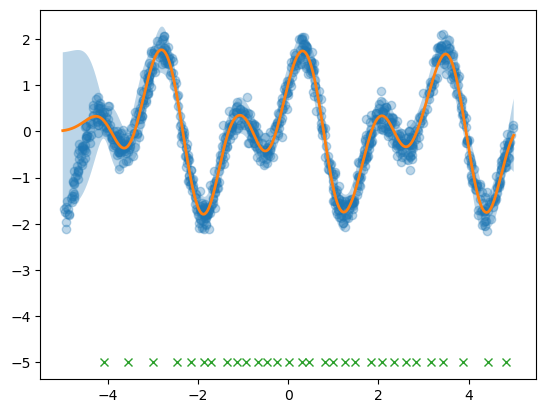

In [ ]:
do_work(n = 30, batch = 50)

1.015277892928949
1.015277892928949  is error for  2
1.015277892928949
1.015277892928949  is error for  3
0.5820227977916443
0.5820227977916443  is error for  4
0.4507679295437979
0.4507679295437979  is error for  5
0.44150723254173424
0.44150723254173424  is error for  6
0.4286908567817802
0.4286908567817802  is error for  7
0.28181181133497263
0.28181181133497263  is error for  8
0.10922136539832251
0.10922136539832251  is error for  9
0.11281737681113384
0.11281737681113384  is error for  10
0.4949060368556254
0.4949060368556254  is error for  11
0.11711237111047088
0.11711237111047088  is error for  12
0.29450284133746846
0.29450284133746846  is error for  13
0.28806272566697094
0.28806272566697094  is error for  14
0.10436854651025514
0.10436854651025514  is error for  15
0.3678697741808718
0.3678697741808718  is error for  16
0.5413635771977018
0.5413635771977018  is error for  17
0.01765848720176756
0.01765848720176756  is error for  18
0.09790897177333131
0.09790897177333131  i

/tmp/ipykernel_446859/2602434696.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


0.0028716797356061587
0.0028716797356061587  is error for  22
0.008391222561566441
0.008391222561566441  is error for  23
0.0029569414938577046
0.0029569414938577046  is error for  24
0.40242066720607556
0.40242066720607556  is error for  25
0.08717413560319191
0.08717413560319191  is error for  26
0.005468005256775027
0.005468005256775027  is error for  27
0.0024857842686572657
0.0024857842686572657  is error for  28
0.3041116859507027
0.3041116859507027  is error for  29
0.0030259055731873224
0.0030259055731873224  is error for  30
0.2412032044676919
0.2412032044676919  is error for  31
0.08580436605890124
0.08580436605890124  is error for  32
0.0017820560465006685
0.0017820560465006685  is error for  33
0.11563460124132546
0.11563460124132546  is error for  34
0.004497045563224037
0.004497045563224037  is error for  35
0.998905820661829
0.998905820661829  is error for  36
0.13905880541932594
0.13905880541932594  is error for  37
0.10712508283735668
0.10712508283735668  is error for 

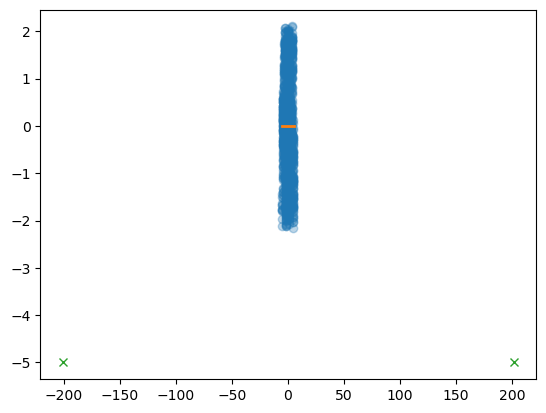

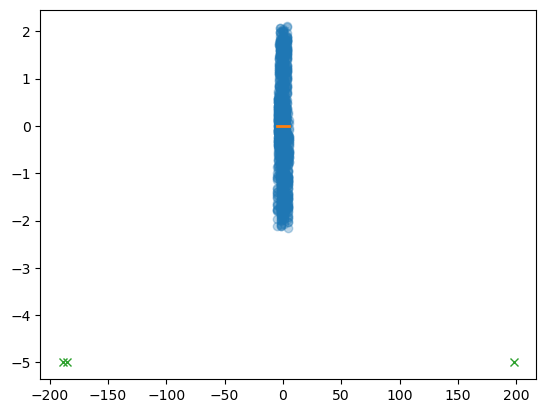

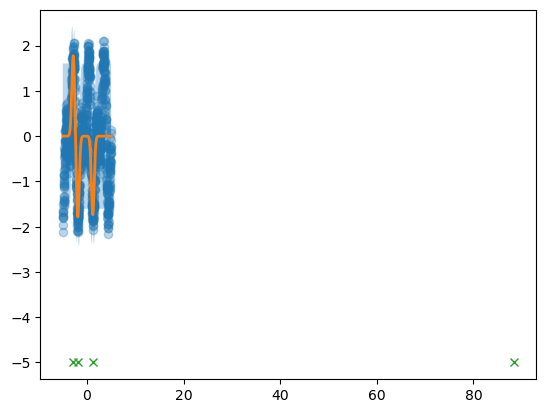

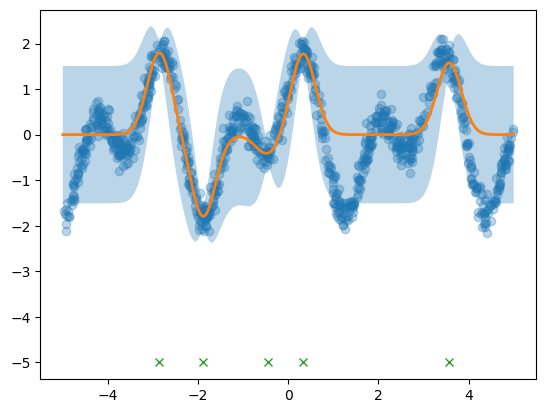

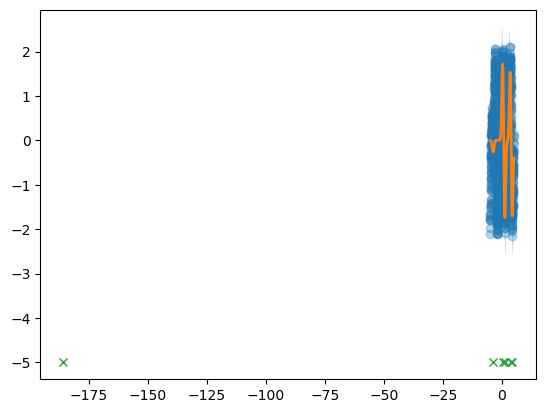

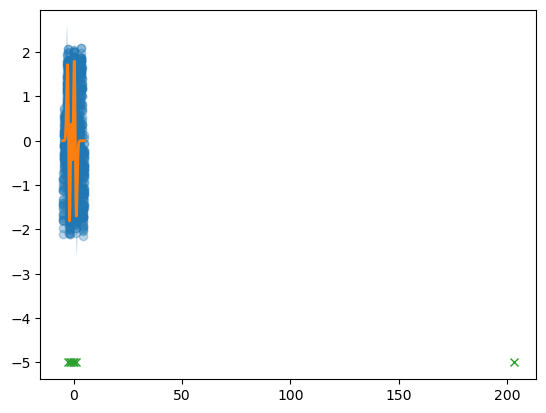

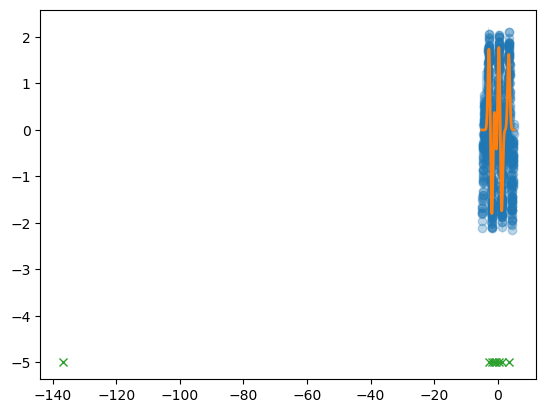

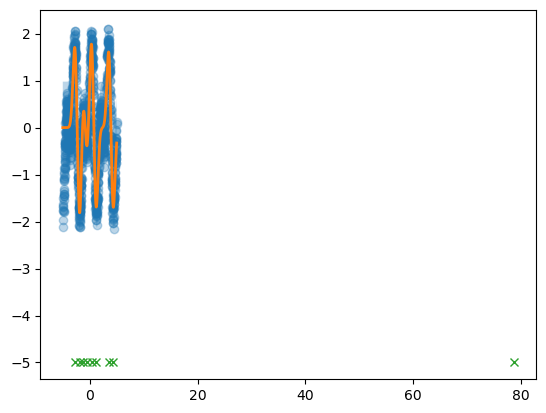

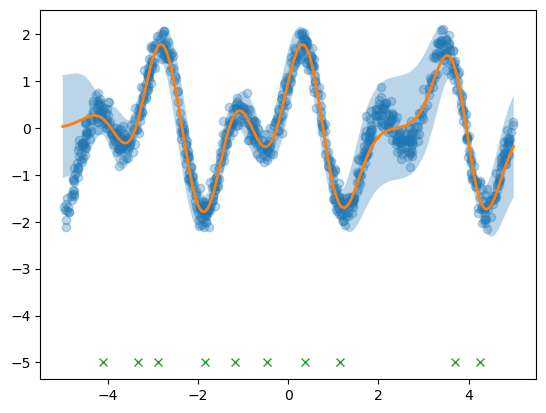

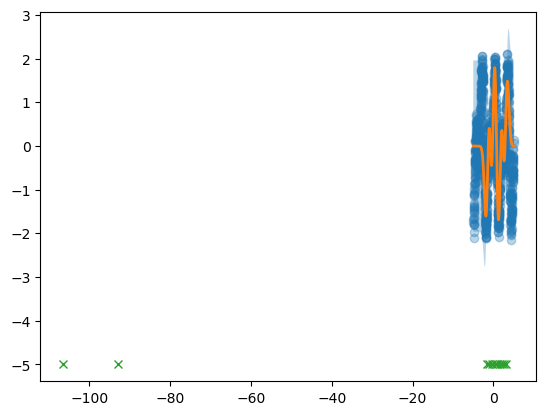

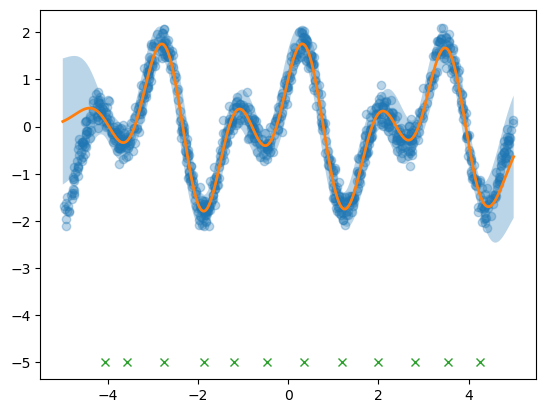

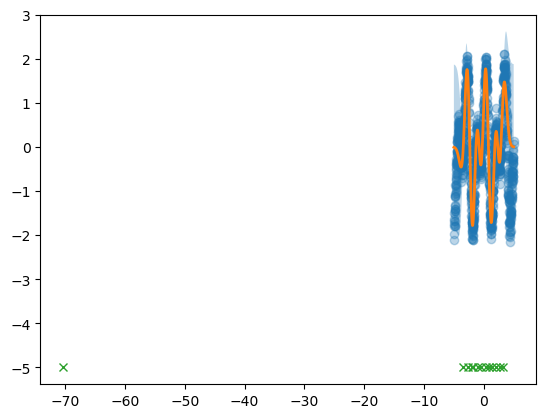

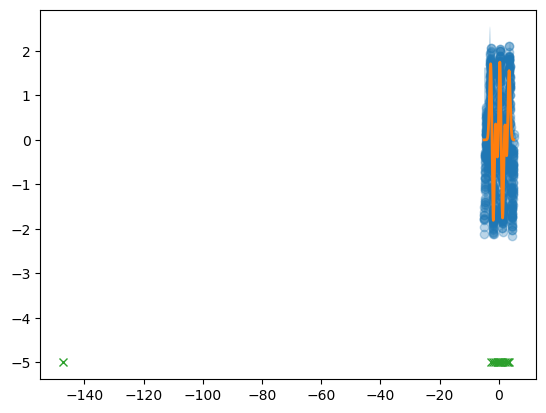

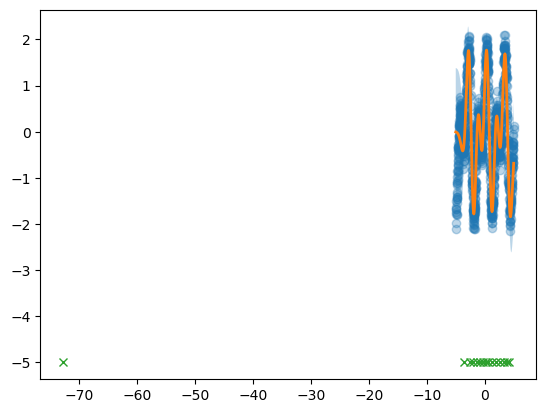

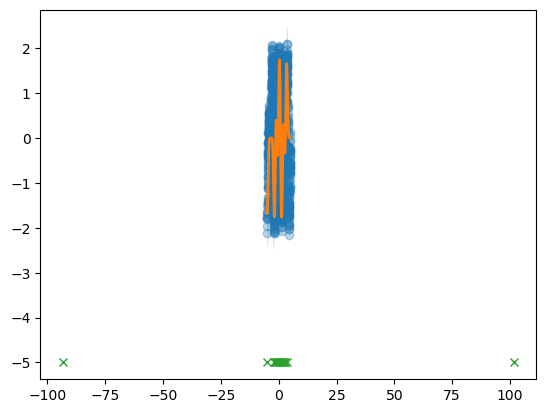

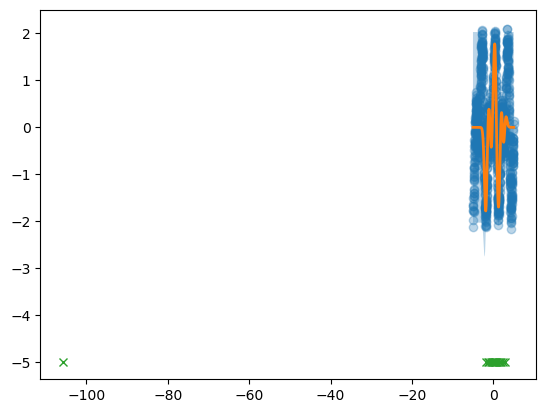

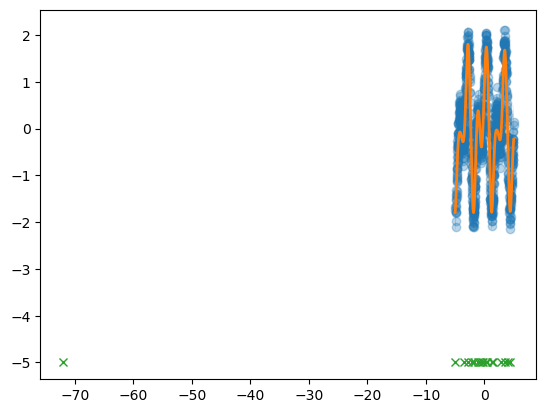

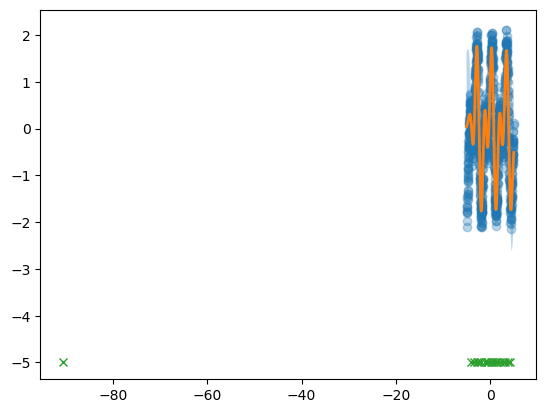

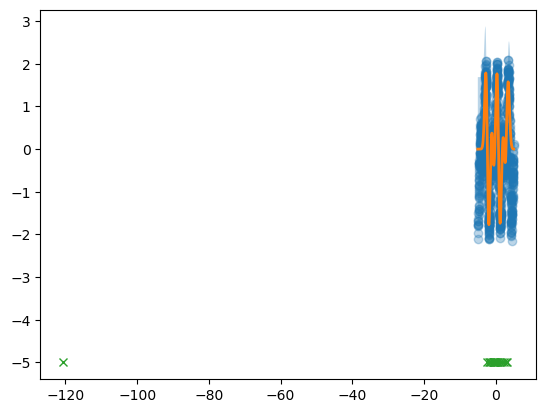

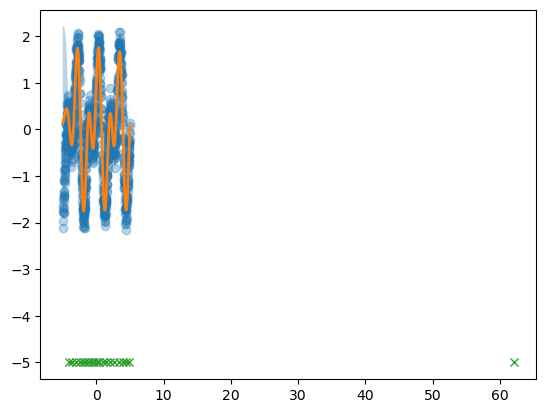

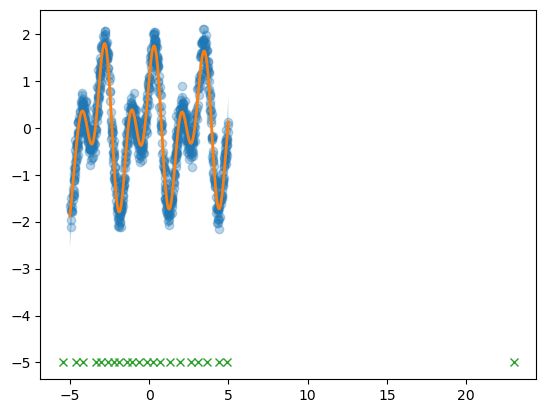

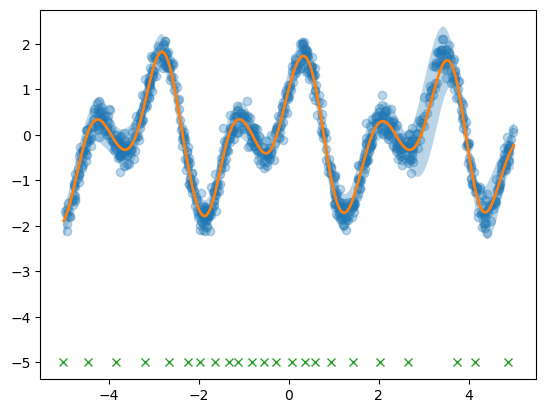

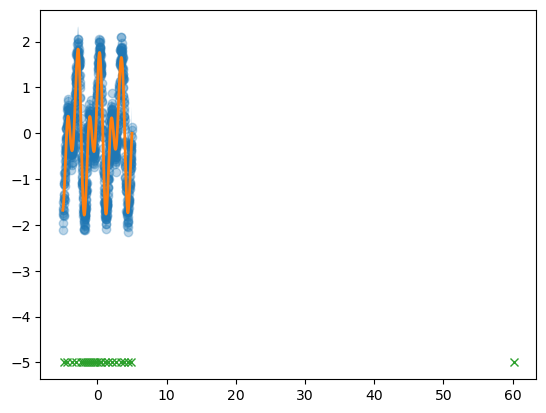

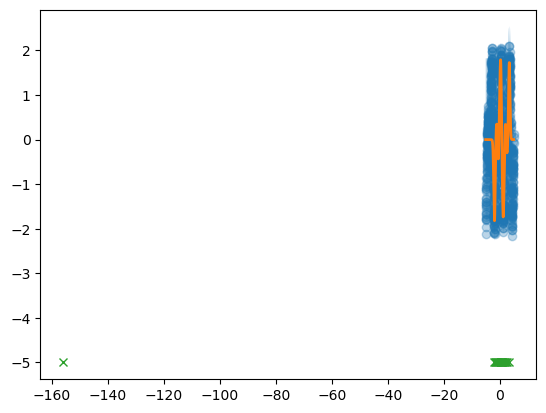

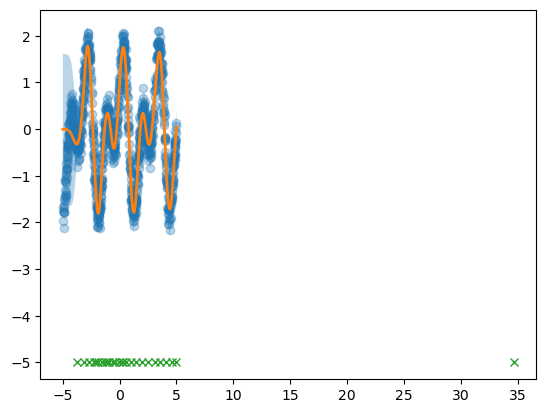

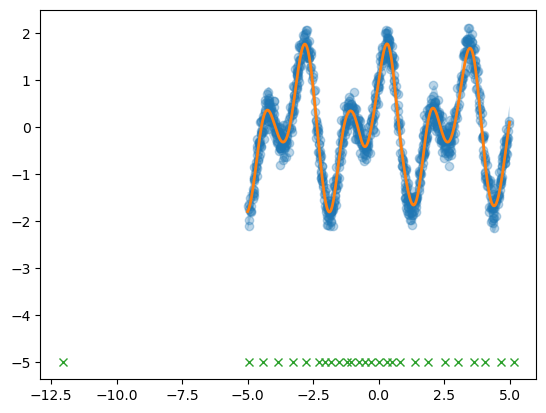

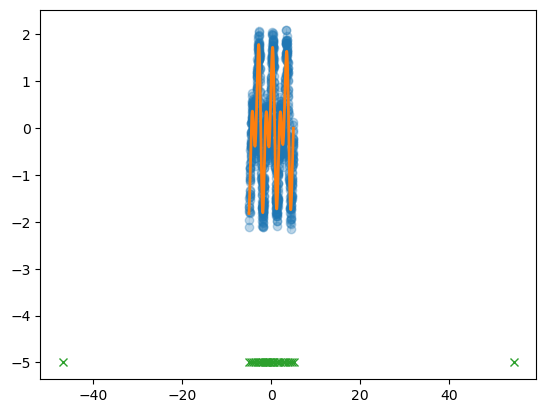

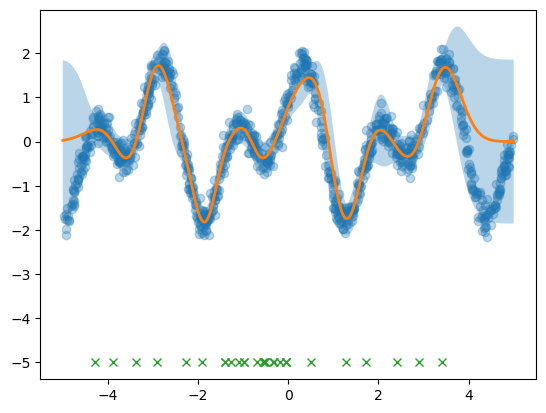

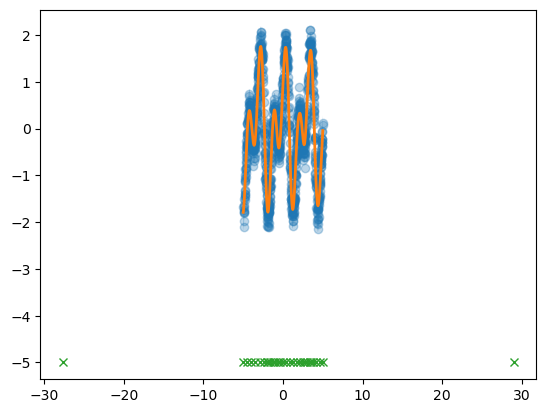

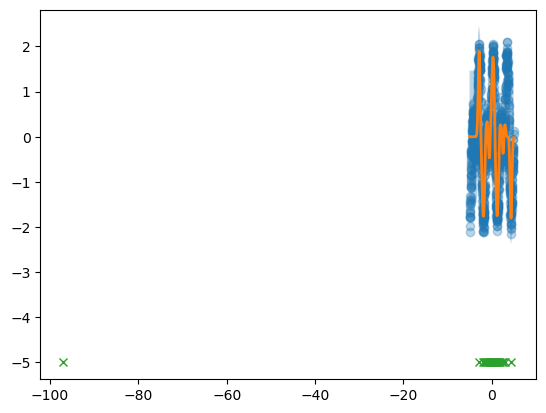

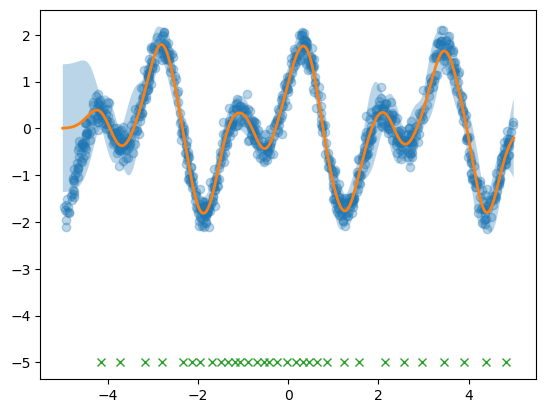

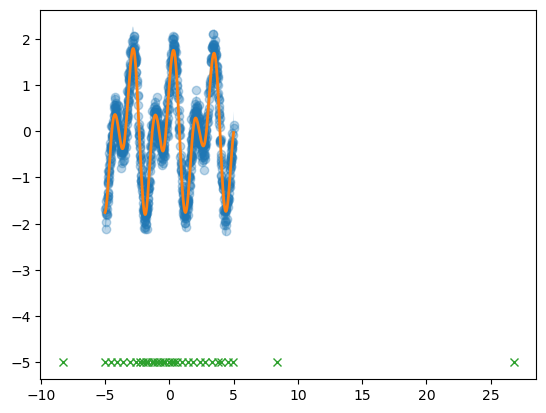

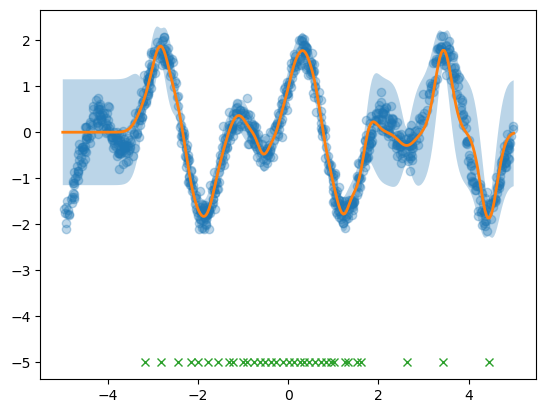

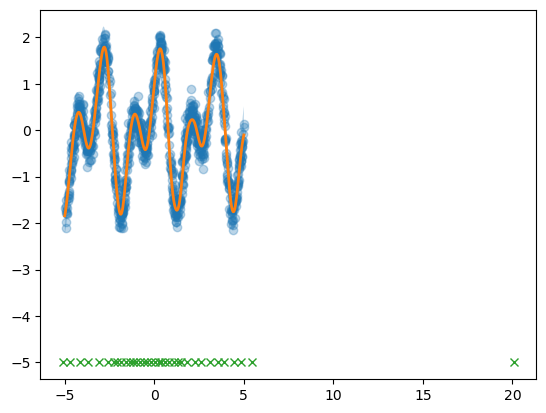

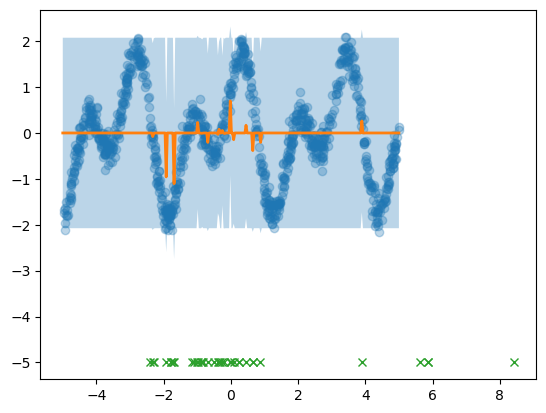

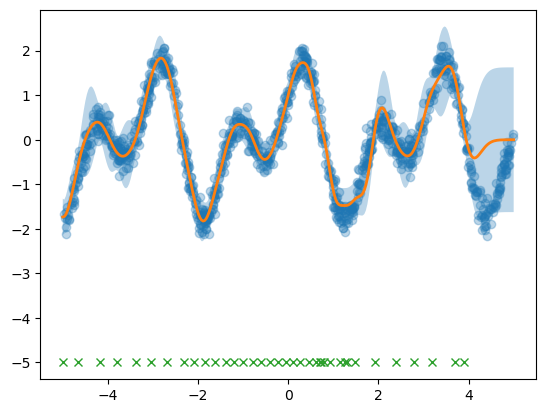

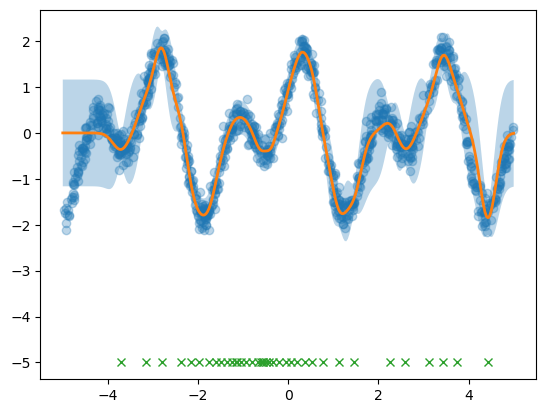

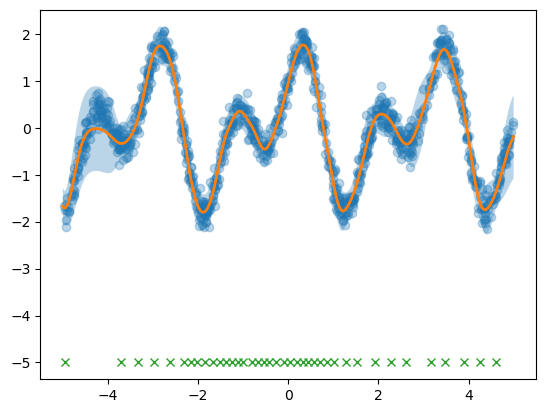

In [ ]:
for n_inducing in range(40)[2:]:
    t = do_work(n_inducing, 50)
    err_lis.append(t)
    print(t, " is error for ", n_inducing)


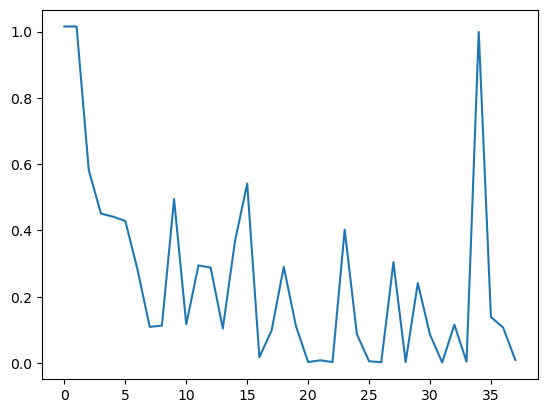

In [ ]:
plt.plot(err_lis)

NameError: name 'pred_mean' is not defined

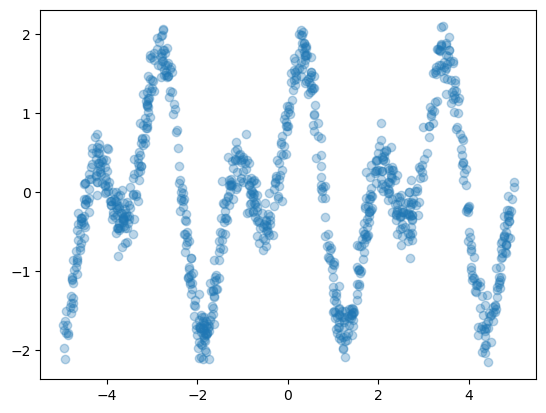

In [13]:
n_inducing = 20
batch_size = 10
key = jax.random.PRNGKey(0)
key2, subkey = jax.random.split(key)
optimizer = optax.adam(learning_rate=0.01)

X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
model = SVGP(X_inducing, data_size)

init_params = model.init_params(key2)

model.loss_fn(init_params, X, y, key)
best_params, loss_history, params_history = model.fit_fn(
    X, y, init_params, optimizer, n_iters, batch_size, subkey)

plt.figure()
# plt.plot(loss_history)
# plt.title("Loss")
x = jnp.linspace(-5, 5, 300)
seed = jax.random.PRNGKey(123)

X1, X2 = jnp.meshgrid(x, x)
def f(x1): return model.predict_fn(best_params, jnp.array([x1]).reshape(1, -1))

plt.plot(X, y, "o", alpha=0.3, label="Samples")
plt.plot(x, pred_mean[0], linewidth=2)
plt.fill_between(x, pred_mean[0] - 2*pred_var[0] **
                0.5, pred_mean[0] + 2*pred_var[0]**0.5, alpha=0.3)
plt.plot(best_params['X_inducing'], jnp.zeros(
    best_params['X_inducing'].shape) - 5, "x")

In [ ]:
X1.shape

(300, 300)

In [ ]:
model.predict_fn(
    best_params, jnp.array([1,2]))

(DeviceArray([-1.13932953,  0.28322825], dtype=float64),
 DeviceArray([0.03768983, 0.03106676], dtype=float64))

In [ ]:

pred_mean, pred_var = jax.vmap(jax.vmap(f))(X1)


In [2]:
for n_inducing in [10,20,30,40,50,60]:
    do_work(n_inducing, 50)

NameError: name 'do_work' is not defined

In [61]:
g(X1)[0]

NameError: name 'g' is not defined

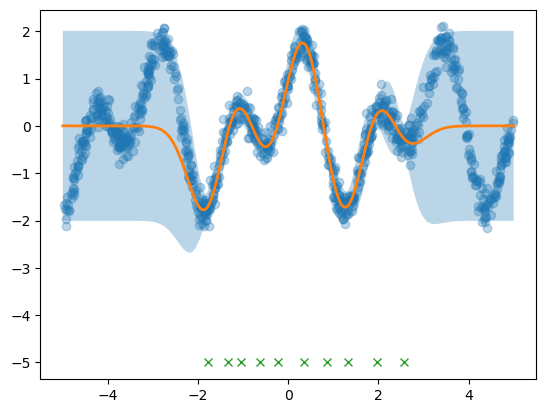

In [68]:
x_ = jnp.linspace(-3.75, 2, 500)
def g(x): return jnp.sin(4 * x) + jnp.cos(2 * x)

jnp.sum((g(X1)[0] - pred_mean[0])**2)/100

DeviceArray(0.07169449, dtype=float64)